> ## Introduction:

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class (5000 for training and 1000 for testing purpose). In this notebook, I try to implement different autoencoders as feature extractor and using those features as inputs to a classifier model, I try to predict the different classes of images in the CIFAR-10 dataset. There is also one more handicap. I used only 50% of the images (3000 images per class) for training and the rest 50% for testing for the following 3 classes: bird, deer and truck. So, the training data is imbalanced.

I used both general convolutional autoencoder and [U-net](https://arxiv.org/pdf/1505.04597.pdf) model as autoencoder for feature extraction purpose. For the classifier model, I used both simple stacked dense layers and also convolution layers and then dense layers. I used hyperopt library to find out the optimized hyperparameters for the classifier model. I also used the class-weight function from the sklearn.utils library for using different class weights to tackle the imbalanced training data.

I found that, U-net architecture (with connector layers) is vastly superior as autoencoders compared to general convolutional autoencoders. But using the features generated from the U-net architecture resulted in low accuracy for the classifier models.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

import keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPool1D, CuDNNLSTM, Reshape
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from keras.datasets import cifar10
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.objectives import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

Using TensorFlow backend.


## Load Data:

I used the keras datasets library to load the training and testing data.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


I created the following dictionary for using it later in visualizations.

In [3]:
dict = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}

## Creating imbalanced data:

I just used the first 2000 images of the bird, deer and truck classes from the training data as test data. In this process, I has 3000 images in both training and test dataset for these 3 classes.

In [4]:
x_test_extra = []
y_test_extra = []
x_train_final = []
y_train_final = []
count = [0, 0, 0]
for i, j in zip(x_train, y_train):
    if (j==2):
        if(count[0]<2000):
            x_test_extra.append(i)
            y_test_extra.append(j)
            count[0]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    elif (j==4):
        if(count[1]<2000):
            x_test_extra.append(i)
            y_test_extra.append(j)
            count[1]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    elif (j==9):
        if(count[2]<2000):
            x_test_extra.append(i)
            y_test_extra.append(j)
            count[2]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    else:
        x_train_final.append(i)
        y_train_final.append(j)
        
x_test_extra = np.array(x_test_extra)
y_test_extra = np.array(y_test_extra)
x_train_final = np.array(x_train_final)
y_train_final = np.array(y_train_final)

In [5]:
x_test_final = np.append(x_test_extra, x_test, axis=0)
y_test_final = np.append(y_test_extra, y_test, axis=0)

## Data Normalization:

Data was normalized because neural networks work better with normalized data.

In [6]:
#x_train_final = x_train    ## These code were used to check model performances with balanced dataset.
#x_test_final = x_test
#y_train_final = y_train
#y_test_final = y_test
x_train_final = x_train_final.astype('float32')
x_test_final = x_test_final.astype('float32')
x_train_final = x_train_final / 255
x_test_final = x_test_final / 255

## Validation split:

I used 20% of the training data as validation set. Validation data was chosen randomly.

In [7]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_trainf, y_validf = train_test_split(x_train_final, y_train_final, test_size=0.2, random_state=42, shuffle= True)

## Target conversion to categorical:

The target variable was converted to one-hot encoded data using the utils.to_categorical function of the keras library.

In [8]:
y_train = keras.utils.to_categorical(y_trainf, 10)
y_valid = keras.utils.to_categorical(y_validf, 10)
y_test_one_hot = keras.utils.to_categorical(y_test_final, 10)

## Necessary functions:

In [9]:
def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x = Conv2D(chs, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
    return x

##############################

## Here, I compute the class weights for using in different models. 
## This is to order our model to emphasize more on classes with less training data.
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(y_trainf), 
                y_trainf.reshape(y_trainf.shape[0]))

class_weights

##############################

def showOrigDec(orig, dec, num=10):  ## function used for visualizing original and reconstructed images of the autoencoder model
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[300*i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[300*i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
        
def show_test(m, d):  ## function used for visualizing the predicted and true labels of test data
    plt.figure(figsize =(40,8))
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        test_image = np.expand_dims(d[1810*i+5], axis=0)
        test_result = m.predict(test_image)
        plt.imshow(x_test_final[1810*i+5])
        index = np.argsort(test_result[0,:])
        plt.title("Pred:{}, True:{}".format(dict[index[9]], dict[y_test_final[1810*i+5][0]]))
    plt.show()
    
def report(predictions): ## function used for creating a classification report and confusion matrix
    cm=confusion_matrix(y_test_one_hot.argmax(axis=1), predictions.argmax(axis=1))
    print("Classification Report:\n")
    cr=classification_report(y_test_one_hot.argmax(axis=1),
                                predictions.argmax(axis=1), 
                                target_names=list(dict.values()))
    print(cr)
    plt.figure(figsize=(12,12))
    sns.heatmap(cm, annot=True, xticklabels = list(dict.values()), yticklabels = list(dict.values()), fmt="d")

## Simple Convolution Model as Classifier:

Here, I have a model that uses several convolution layers stacked and followed by a dense layer with 10 output nodes and softmax activation. It is used as a single classifier model that I can use as a benchmark model. Dropout layers are used for reducing overfitting.

In [10]:
def full_conv():
    input = Input((32,32,3))
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    x = Dropout(0.2)(x)
    block2 = create_block(x, 64)
    x = MaxPool2D(2)(block2)
    x = Dropout(0.3)(x)
    block3 = create_block(x, 128)
    x = MaxPool2D(2)(block3)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    output = Dense(10, activation='softmax')(x)
    return Model(input, output)

conv_model = full_conv()
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
__________

In [11]:
#training
batch_size = 512
epochs=20
opt_rms = Adadelta()
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=opt_rms,
                   metrics=['accuracy'])

In [12]:
def run_conv_model(data_aug):
    er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
    callbacks = [er, lr]
    
    if not data_aug:
        history = conv_model.fit(x_train, y_train, batch_size=512,
                                 epochs=epochs,
                                 verbose=1, callbacks=callbacks,
                                 validation_data=(x_valid,y_valid),
                                 class_weight=class_weights)
    else:
        train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
        train_set_ae = train_datagen.flow(x_train, y_train, batch_size=512)

        validation_datagen = ImageDataGenerator()
        validation_set_ae = validation_datagen.flow(x_valid, y_valid, batch_size=512)
        
        history = conv_model.fit_generator(train_set_ae,
                                           epochs=epochs,
                                           steps_per_epoch=np.ceil(x_train.shape[0]/512),
                                           verbose=1, callbacks=callbacks,
                                           validation_data=(validation_set_ae),
                                           validation_steps=np.ceil(x_valid.shape[0]/512),
                                           class_weight=class_weights)
        
        return history

In [13]:
run_conv_model(1)

Epoch 1/20
69/69 [==============================] - 16s 230ms/step - loss: 2.2430 - acc: 0.3589 - val_loss: 1.6344 - val_acc: 0.4248
Epoch 2/20
69/69 [==============================] - 13s 187ms/step - loss: 1.5763 - acc: 0.4749 - val_loss: 2.2698 - val_acc: 0.3468
Epoch 3/20
69/69 [==============================] - 14s 197ms/step - loss: 1.3446 - acc: 0.5409 - val_loss: 1.3498 - val_acc: 0.5489
Epoch 4/20
69/69 [==============================] - 13s 189ms/step - loss: 1.2132 - acc: 0.5909 - val_loss: 1.3723 - val_acc: 0.5717
Epoch 5/20
69/69 [==============================] - 13s 189ms/step - loss: 1.0800 - acc: 0.6317 - val_loss: 1.1034 - val_acc: 0.6232
Epoch 6/20
69/69 [==============================] - 13s 192ms/step - loss: 1.0079 - acc: 0.6550 - val_loss: 1.1452 - val_acc: 0.6375
Epoch 7/20
69/69 [==============================] - 13s 188ms/step - loss: 0.9322 - acc: 0.6832 - val_loss: 0.8985 - val_acc: 0.7000
Epoch 8/20
69/69 [==============================] - 13s 187ms/step - 

In [14]:
print('Test accuracy for benchmark model= {}'.format(conv_model.evaluate(x_test_final, y_test_one_hot)[1]))

16000/16000 [==============================] - 1s 85us/step
Test accuracy for benchmark model= 0.758375


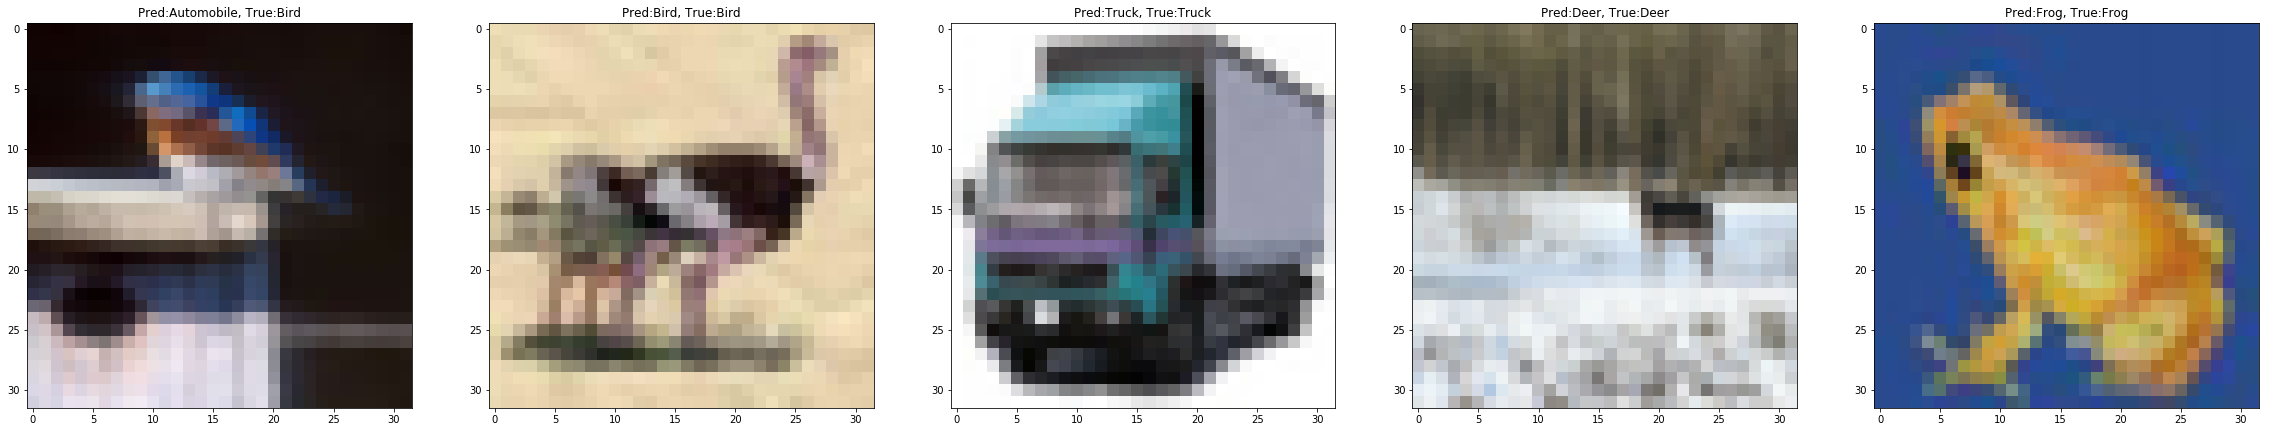

In [15]:
show_test(conv_model, x_test_final)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.68      0.84      0.75      1000
  Automobile       0.77      0.93      0.84      1000
        Bird       0.90      0.58      0.70      3000
         Cat       0.60      0.57      0.58      1000
        Deer       0.87      0.73      0.79      3000
         Dog       0.73      0.60      0.66      1000
        Frog       0.38      0.97      0.55      1000
       Horse       0.82      0.80      0.81      1000
        Ship       0.83      0.92      0.87      1000
       Truck       0.95      0.86      0.90      3000

    accuracy                           0.76     16000
   macro avg       0.75      0.78      0.75     16000
weighted avg       0.81      0.76      0.77     16000



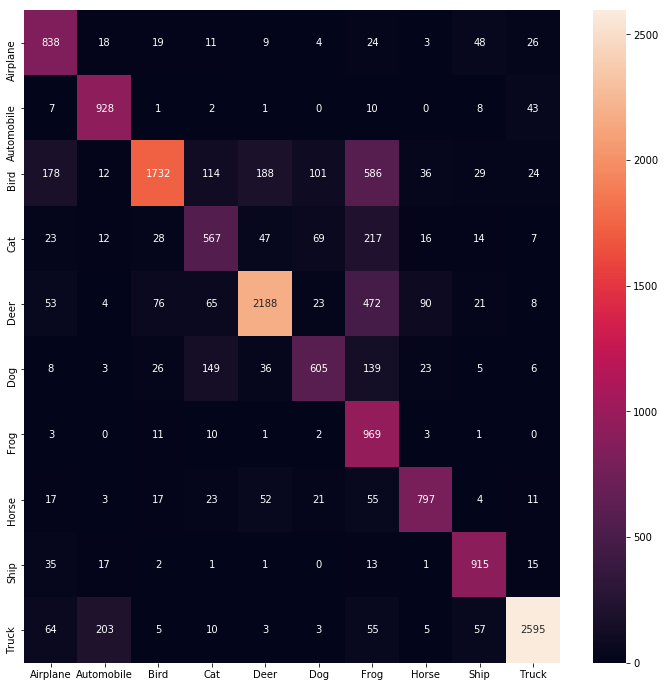

In [16]:
predictions = conv_model.predict(x_test_final)
report(predictions)

From the confusion matrix, we can see that, the model works quite good with only 20 epochs for all the classes inspite of the imbalanced data. It only had problem identifying birds correctly. I found that, the result was worse when I did not use class weights. The model accuracy is also improved by augmenting data.

## Autoencoder Model:

In [17]:
def unet():  ## I commented several layers of the model for descreasing model complexity as the results were almost same
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 16)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 32)
    #x = MaxPool2D(2)(block2)
    #block3 = create_block(x, 64)
    #x = MaxPool2D(2)(block3)
    #block4 = create_block(x, 128)
    
    # Middle
    x = MaxPool2D(2)(block2)
    middle = create_block(x, 64)
    
    # Decoder
    #x = Conv2DTranspose(128, kernel_size=2, strides=2)(middle)
    #x = Concatenate()([block4, x])
    #x = create_block(x, 128)
    #x = Conv2DTranspose(64, kernel_size=2, strides=2)(x)
    #x = Concatenate()([block3, x])
    #x = create_block(x, 64)
    x = Conv2DTranspose(32, kernel_size=2, strides=2)(middle)
    x = Concatenate()([block2, x])
    x = create_block(x, 32)
    x = Conv2DTranspose(16, kernel_size=2, strides=2)(x)
    x = Concatenate()([block1, x])
    x = create_block(x, 16)
    
    # output
    x = Conv2D(3, 1)(x)
    output = Activation("sigmoid")(x)
    
    return Model(input, middle), Model(input, output)

def general_ae():
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPool2D(2)(block1)
    block2 = create_block(x, 64)
    
    #Middle
    x = MaxPool2D(2)(block2)
    middle = create_block(x, 128)
    
    # Decoder
    block3 = create_block(middle, 64)
    up1 = UpSampling2D((2,2))(block3)
    block4 = create_block(up1, 32)
    up2 = UpSampling2D((2,2))(block4)
    
    # output
    x = Conv2D(3, 1)(up2)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)

In [18]:
def run_ae(m):  ## function for choosing unet/general autoencoder
    if m=='unet':
        encoder, model = unet()
    elif m=='ae':
        encoder, model = general_ae()
        
    return encoder, model

In [19]:
def loss_function(y_true, y_pred):  ## loss function for using in autoencoder models
    mses = mean_squared_error(y_true, y_pred)
    return K.sum(mses, axis=(1,2))

## Implementing U-Net:

In [20]:
encoder_unet, model_unet = run_ae('unet')
model_unet.compile(SGD(1e-3, 0.9), loss=loss_function)
model_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 32, 32, 16)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 32, 32, 16)   64          activation_7[0][0]               
__________________________________________________________________________________________________
conv2d_8 (

In [21]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
history = model_unet.fit(x_train, x_train, 
                         batch_size=512,
                         epochs=100,
                         verbose=1,
                         validation_data=(x_valid, x_valid),
                         shuffle=True, callbacks=callbacks,
                         class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 7s 189us/step - loss: 8.5363 - val_loss: 6.5108
Epoch 2/100
35200/35200 [==============================] - 4s 120us/step - loss: 2.6848 - val_loss: 2.4402
Epoch 3/100
35200/35200 [==============================] - 4s 121us/step - loss: 1.7570 - val_loss: 1.9871
Epoch 4/100
35200/35200 [==============================] - 4s 119us/step - loss: 1.3748 - val_loss: 1.6665
Epoch 5/100
35200/35200 [==============================] - 4s 120us/step - loss: 1.1304 - val_loss: 1.4059
Epoch 6/100
35200/35200 [==============================] - 4s 119us/step - loss: 0.9765 - val_loss: 1.2550
Epoch 7/100
35200/35200 [==============================] - 4s 121us/step - loss: 0.8663 - val_loss: 1.1156
Epoch 8/100
35200/35200 [==============================] - 4s 120us/step - loss: 0.8018 - val_loss: 1.0116
Epoch 9/100
35200/35200 [==============================] - 4s 120us/step - loss: 0.7538 - val_l

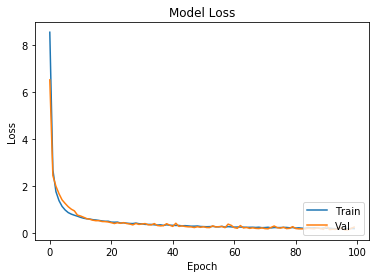

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [23]:
recon_test_unet = model_unet.predict(x_test_final)
recon_valid_unet = model_unet.predict(x_valid)

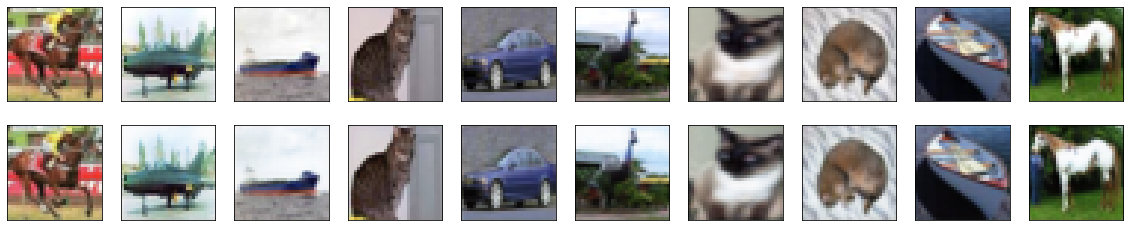

In [24]:
showOrigDec(x_valid, recon_valid_unet)

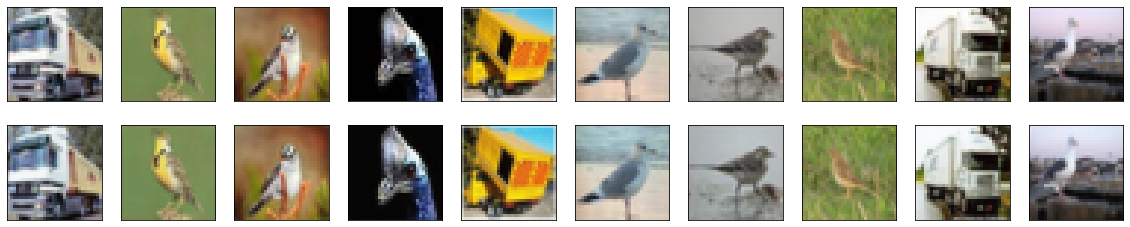

In [25]:
showOrigDec(x_test_final, recon_test_unet)

## Implement Convolutional AE:

In [26]:
encoder_ae, model_ae = run_ae('ae')
model_ae.compile(SGD(1e-3, 0.9), loss=loss_function)
model_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
__________

In [27]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
history = model_ae.fit(x_train, x_train, 
                       batch_size=512,
                       epochs=100,
                       verbose=1,
                       validation_data=(x_valid, x_valid),
                       shuffle=True, callbacks=callbacks,
                       class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 6s 183us/step - loss: 19.9453 - val_loss: 18.7242
Epoch 2/100
35200/35200 [==============================] - 4s 120us/step - loss: 11.3520 - val_loss: 10.8273
Epoch 3/100
35200/35200 [==============================] - 4s 121us/step - loss: 10.0012 - val_loss: 9.7733
Epoch 4/100
35200/35200 [==============================] - 4s 120us/step - loss: 9.3374 - val_loss: 9.2155
Epoch 5/100
35200/35200 [==============================] - 4s 121us/step - loss: 8.8448 - val_loss: 8.9228
Epoch 6/100
35200/35200 [==============================] - 4s 120us/step - loss: 8.3880 - val_loss: 8.7235
Epoch 7/100
35200/35200 [==============================] - 4s 120us/step - loss: 8.1191 - val_loss: 8.3822
Epoch 8/100
35200/35200 [==============================] - 4s 120us/step - loss: 7.8417 - val_loss: 7.9725
Epoch 9/100
35200/35200 [==============================] - 4s 120us/step - loss: 7.6543 - 

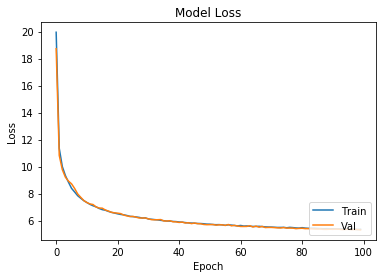

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [29]:
recon_test_ae = model_ae.predict(x_test_final)
recon_valid_ae = model_ae.predict(x_valid)

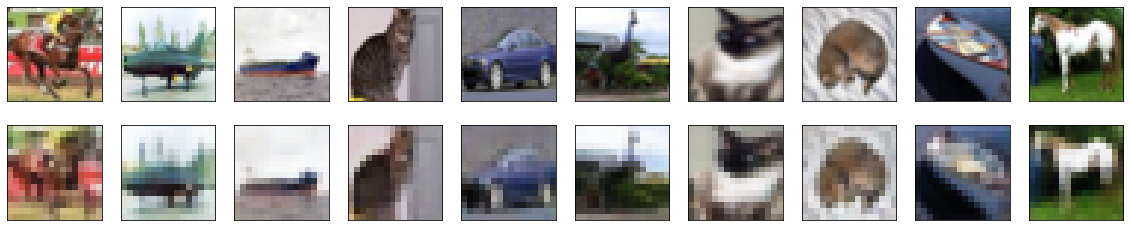

In [30]:
showOrigDec(x_valid, recon_valid_ae)

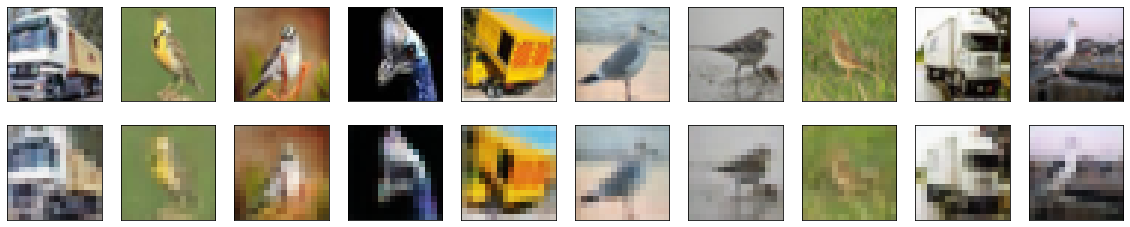

In [31]:
showOrigDec(x_test_final, recon_test_ae)

As we can see, unet architecture is far better in terms of reconstructing the data.

## Extracting bottleneck features to use as inputs in the classifier model:

In [32]:
gist_train_unet = encoder_unet.predict(x_train)
gist_valid_unet = encoder_unet.predict(x_valid)
gist_test_unet = encoder_unet.predict(x_test_final)

gist_train_ae = encoder_ae.predict(x_train)
gist_valid_ae = encoder_ae.predict(x_valid)
gist_test_ae = encoder_ae.predict(x_test_final)

## Classifier Models:

In [33]:
def classifier_dense(inp):
    input = Input((inp.shape[1], inp.shape[2], inp.shape[3]))
    #x = MaxPool2D()(input)
    x = Flatten()(input)
    #x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.64)(x)
    x = Dense(50, activation='relu')(x)
    #x = Reshape((-1, 1))(x)
    #x = Conv1D(128, (3,), activation='relu', padding='same')(x)
    #x = MaxPool1D()(x)
    #x = CuDNNLSTM(64)(x)
    #x = Flatten()(x)
    x = Dropout(0.4)(x)
    output = Dense(10, activation='softmax')(x)
    return Model(input, output)

def classifier_conv(inp):
    input = Input((inp.shape[1], inp.shape[2], inp.shape[3]))
    x = Conv2D(1024, 3, padding="same")(input)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.5)(x)
    x = Conv2D(128, 3, padding="same")(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.35)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.69)(x)
    output = Dense(10, activation='softmax')(x)
    return Model(input, output)

In [34]:
def run_cls(m, inp):  ## function for choosing dense/convolutional classifier model
    if m=='dense':
        classifier = classifier_dense(inp)
    elif m=='conv':
        classifier = classifier_conv(inp)
        
    return classifier

## Convolutional AE with convolutional NN as classifier:

In [35]:
decoder_ae_conv = run_cls('conv', gist_train_ae)
decoder_ae_conv.compile(loss='categorical_crossentropy',
                        optimizer=Adadelta(),
                        metrics=['accuracy'])
decoder_ae_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 1024)        1180672   
_________________________________________________________________
activation_29 (Activation)   (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 8, 8, 1024)        4096      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 1024)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 4, 4, 128)         1179776   
__________

In [36]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
hist1 = decoder_ae_conv.fit(gist_train_ae, y_train, batch_size=512, epochs=100, 
                            validation_data = (gist_valid_ae, y_valid),
                            shuffle=True, callbacks=callbacks,
                            class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 5s 155us/step - loss: 2.3583 - acc: 0.1742 - val_loss: 1.9606 - val_acc: 0.2958
Epoch 2/100
35200/35200 [==============================] - 3s 95us/step - loss: 2.0194 - acc: 0.2531 - val_loss: 1.7531 - val_acc: 0.3553
Epoch 3/100
35200/35200 [==============================] - 3s 95us/step - loss: 1.8657 - acc: 0.3147 - val_loss: 1.7226 - val_acc: 0.3775
Epoch 4/100
35200/35200 [==============================] - 3s 95us/step - loss: 1.7507 - acc: 0.3594 - val_loss: 1.5072 - val_acc: 0.4442
Epoch 5/100
35200/35200 [==============================] - 3s 95us/step - loss: 1.6386 - acc: 0.4037 - val_loss: 1.3816 - val_acc: 0.5080
Epoch 6/100
35200/35200 [==============================] - 3s 95us/step - loss: 1.5734 - acc: 0.4363 - val_loss: 1.3163 - val_acc: 0.5189
Epoch 7/100
35200/35200 [==============================] - 3s 96us/step - loss: 1.5001 - acc: 0.4625 - val_loss: 1.2590 - 

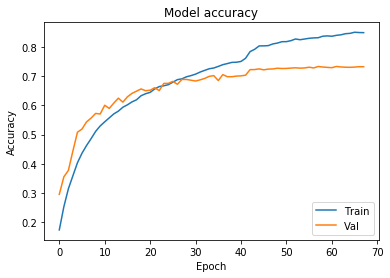

In [37]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [38]:
print('Test accuracy for AE_conv model= {}'.format(decoder_ae_conv.evaluate(gist_test_ae, y_test_one_hot)[1]))

16000/16000 [==============================] - 2s 106us/step
Test accuracy for AE_conv model= 0.679625


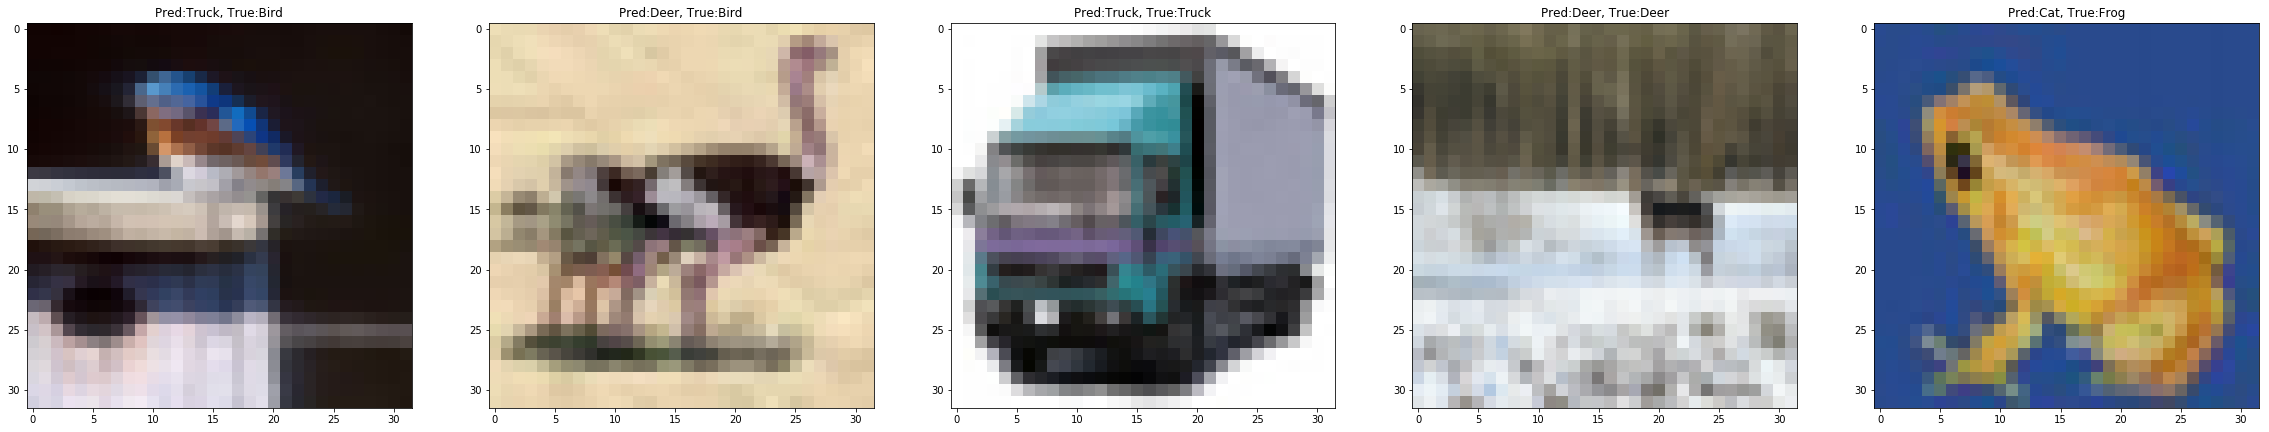

In [39]:
show_test(decoder_ae_conv, gist_test_ae)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.59      0.81      0.68      1000
  Automobile       0.68      0.84      0.75      1000
        Bird       0.82      0.49      0.62      3000
         Cat       0.36      0.53      0.43      1000
        Deer       0.80      0.60      0.69      3000
         Dog       0.47      0.66      0.55      1000
        Frog       0.58      0.83      0.68      1000
       Horse       0.59      0.79      0.67      1000
        Ship       0.73      0.86      0.79      1000
       Truck       0.92      0.75      0.83      3000

    accuracy                           0.68     16000
   macro avg       0.65      0.72      0.67     16000
weighted avg       0.73      0.68      0.68     16000



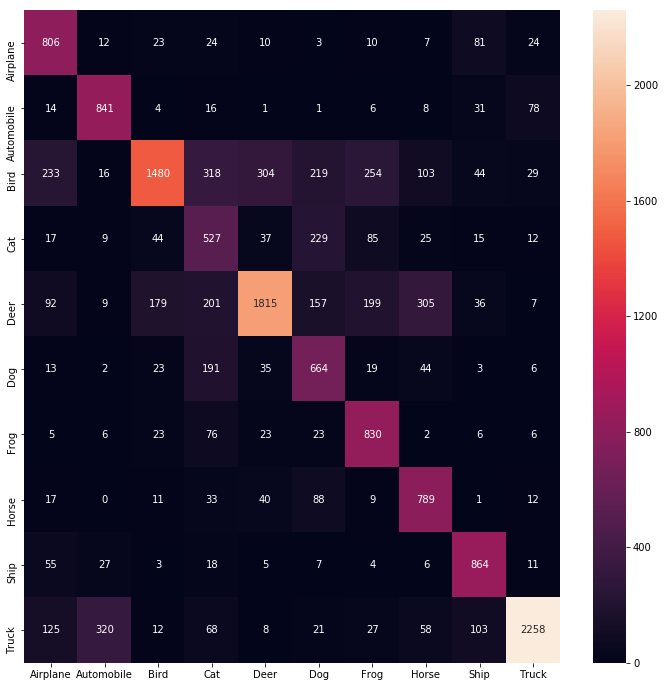

In [40]:
predictions = decoder_ae_conv.predict(gist_test_ae)
report(predictions)

## Convolutional AE with simple NN as classifier:

In [41]:
decoder_ae_dense = run_cls('dense', gist_train_ae)
decoder_ae_dense.compile(loss='categorical_crossentropy',
                         optimizer=Adadelta(),
                         metrics=['accuracy'])
decoder_ae_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                25650     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
Total para

In [42]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
hist1 = decoder_ae_dense.fit(gist_train_ae, y_train, batch_size=512, epochs=100, 
                             validation_data = (gist_valid_ae, y_valid),
                             shuffle=True, callbacks=callbacks,
                             class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 3s 72us/step - loss: 2.3263 - acc: 0.2370 - val_loss: 1.8042 - val_acc: 0.4072
Epoch 2/100
35200/35200 [==============================] - 1s 37us/step - loss: 1.9172 - acc: 0.3322 - val_loss: 1.6541 - val_acc: 0.4451
Epoch 3/100
35200/35200 [==============================] - 1s 37us/step - loss: 1.7864 - acc: 0.3728 - val_loss: 1.5242 - val_acc: 0.4809
Epoch 4/100
35200/35200 [==============================] - 1s 37us/step - loss: 1.6861 - acc: 0.4106 - val_loss: 1.4718 - val_acc: 0.4968
Epoch 5/100
35200/35200 [==============================] - 1s 37us/step - loss: 1.6076 - acc: 0.4358 - val_loss: 1.4007 - val_acc: 0.5241
Epoch 6/100
35200/35200 [==============================] - 1s 37us/step - loss: 1.5463 - acc: 0.4551 - val_loss: 1.3729 - val_acc: 0.5249
Epoch 7/100
35200/35200 [==============================] - 1s 37us/step - loss: 1.4859 - acc: 0.4822 - val_loss: 1.3204 - v

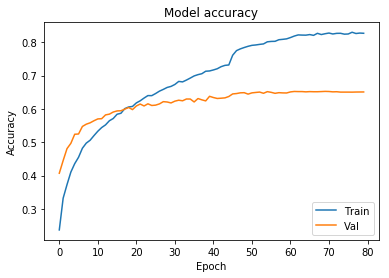

In [43]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [44]:
print('Test accuracy for AE_dense model= {}'.format(decoder_ae_dense.evaluate(gist_test_ae, y_test_one_hot)[1]))

16000/16000 [==============================] - 1s 68us/step
Test accuracy for AE_dense model= 0.5743125


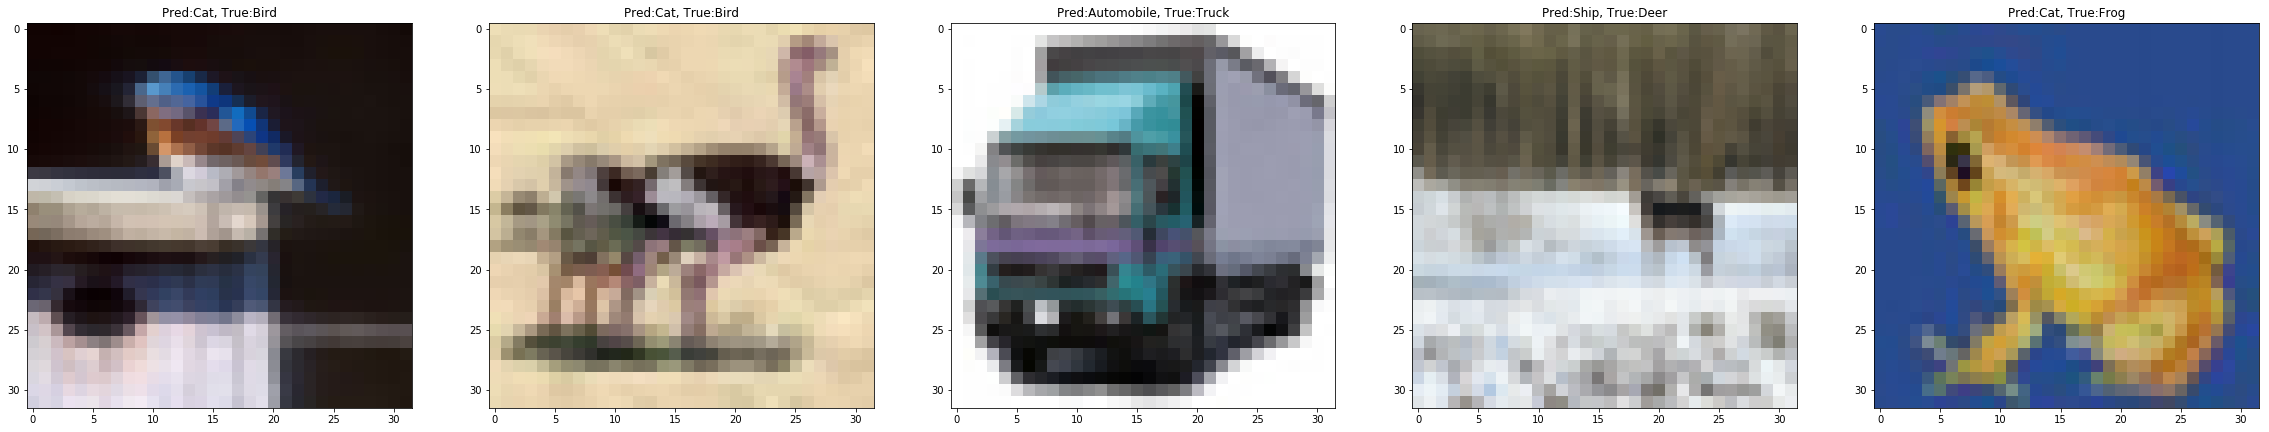

In [45]:
show_test(decoder_ae_dense, gist_test_ae)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.48      0.74      0.59      1000
  Automobile       0.50      0.82      0.62      1000
        Bird       0.74      0.40      0.52      3000
         Cat       0.29      0.52      0.38      1000
        Deer       0.72      0.47      0.57      3000
         Dog       0.39      0.54      0.45      1000
        Frog       0.48      0.76      0.59      1000
       Horse       0.50      0.72      0.59      1000
        Ship       0.65      0.79      0.71      1000
       Truck       0.90      0.57      0.70      3000

    accuracy                           0.57     16000
   macro avg       0.57      0.63      0.57     16000
weighted avg       0.65      0.57      0.58     16000



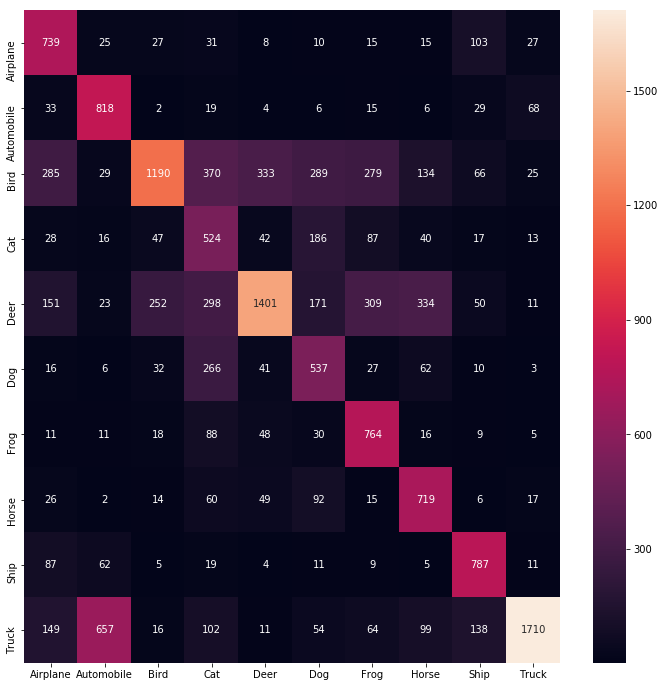

In [46]:
predictions = decoder_ae_dense.predict(gist_test_ae)
report(predictions)

## Unet with convolutional NN as classifier:

In [47]:
decoder_un_conv = run_cls('conv', gist_train_unet)
decoder_un_conv.compile(loss='categorical_crossentropy',
                         optimizer=Adadelta(),
                         metrics=['accuracy'])
decoder_un_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 1024)        590848    
_________________________________________________________________
activation_31 (Activation)   (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 8, 8, 1024)        4096      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 1024)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 4, 128)         1179776   
__________

In [48]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
hist1 = decoder_un_conv.fit(gist_train_unet, y_train, batch_size=512, epochs=100, 
                            validation_data = (gist_valid_unet, y_valid),
                            shuffle=True, callbacks=callbacks,
                            class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 5s 131us/step - loss: 2.3785 - acc: 0.1697 - val_loss: 2.0523 - val_acc: 0.2558
Epoch 2/100
35200/35200 [==============================] - 3s 74us/step - loss: 2.1201 - acc: 0.2219 - val_loss: 1.8542 - val_acc: 0.3294
Epoch 3/100
35200/35200 [==============================] - 3s 74us/step - loss: 1.9721 - acc: 0.2818 - val_loss: 1.7262 - val_acc: 0.3782
Epoch 4/100
35200/35200 [==============================] - 3s 74us/step - loss: 1.8774 - acc: 0.3242 - val_loss: 1.6606 - val_acc: 0.4036
Epoch 5/100
35200/35200 [==============================] - 3s 74us/step - loss: 1.7861 - acc: 0.3574 - val_loss: 1.6317 - val_acc: 0.4060
Epoch 6/100
35200/35200 [==============================] - 3s 74us/step - loss: 1.7251 - acc: 0.3853 - val_loss: 1.5251 - val_acc: 0.4540
Epoch 7/100
35200/35200 [==============================] - 3s 74us/step - loss: 1.6660 - acc: 0.4055 - val_loss: 1.5402 - 

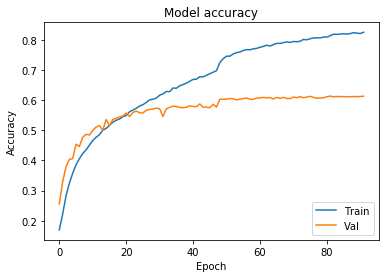

In [49]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [50]:
print('Test accuracy for Unet_conv model= {}'.format(decoder_un_conv.evaluate(gist_test_unet, y_test_one_hot)[1]))

16000/16000 [==============================] - 2s 94us/step
Test accuracy for Unet_conv model= 0.54775


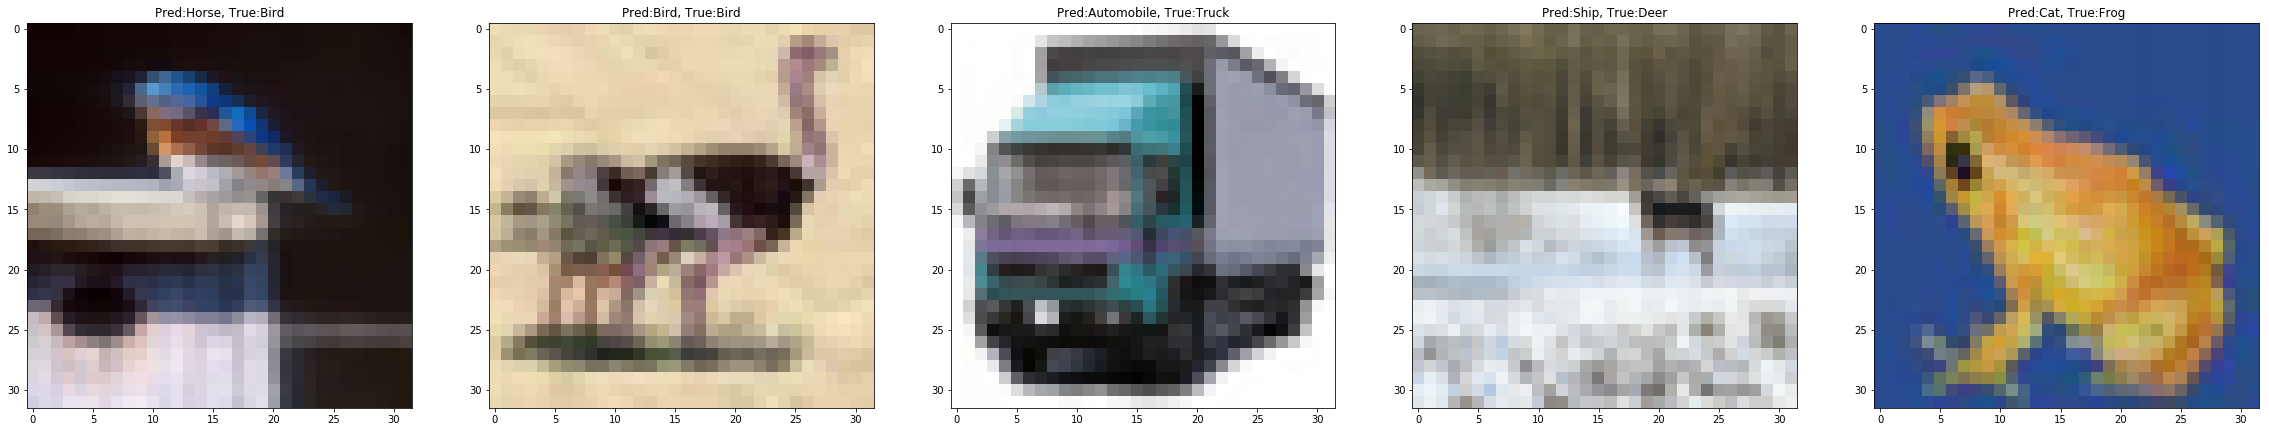

In [51]:
show_test(decoder_un_conv, gist_test_unet)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.47      0.70      0.57      1000
  Automobile       0.55      0.70      0.61      1000
        Bird       0.65      0.37      0.47      3000
         Cat       0.28      0.44      0.34      1000
        Deer       0.67      0.43      0.52      3000
         Dog       0.38      0.53      0.44      1000
        Frog       0.43      0.76      0.54      1000
       Horse       0.47      0.70      0.56      1000
        Ship       0.60      0.74      0.66      1000
       Truck       0.85      0.60      0.70      3000

    accuracy                           0.55     16000
   macro avg       0.53      0.60      0.54     16000
weighted avg       0.61      0.55      0.55     16000



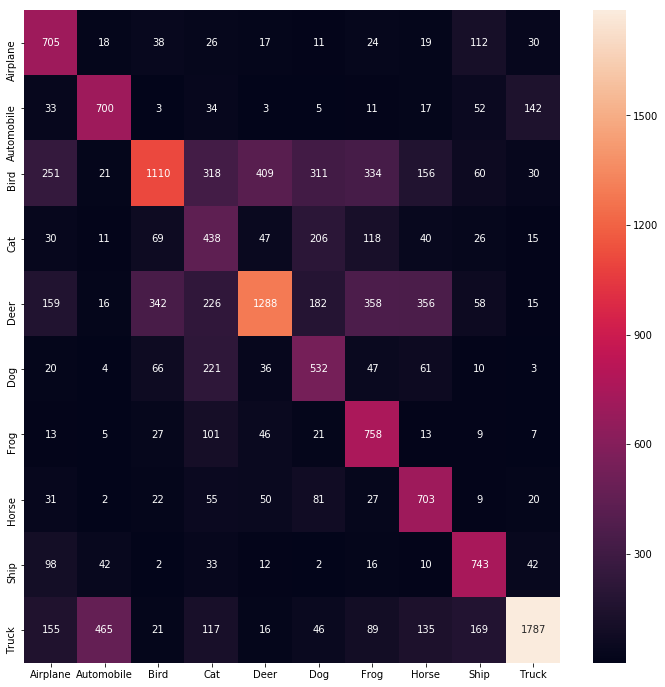

In [52]:
predictions = decoder_un_conv.predict(gist_test_unet)
report(predictions)

## Unet with simple NN as classifier:

In [53]:
decoder_un_dense = run_cls('dense', gist_train_unet)
decoder_un_dense.compile(loss='categorical_crossentropy',
                         optimizer=Adadelta(),
                         metrics=['accuracy'])
decoder_un_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               2097664   
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                25650     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                510       
Total para

In [54]:
er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [er, lr]
hist1 = decoder_un_dense.fit(gist_train_unet, y_train, batch_size=512, epochs=100, 
                             validation_data = (gist_valid_unet, y_valid),
                             shuffle=True, callbacks=callbacks,
                             class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 2s 63us/step - loss: 2.2000 - acc: 0.2503 - val_loss: 1.7952 - val_acc: 0.3844
Epoch 2/100
35200/35200 [==============================] - 1s 21us/step - loss: 1.8788 - acc: 0.3330 - val_loss: 1.6750 - val_acc: 0.4317
Epoch 3/100
35200/35200 [==============================] - 1s 20us/step - loss: 1.7580 - acc: 0.3768 - val_loss: 1.5991 - val_acc: 0.4538
Epoch 4/100
35200/35200 [==============================] - 1s 20us/step - loss: 1.6755 - acc: 0.4036 - val_loss: 1.5205 - val_acc: 0.4642
Epoch 5/100
35200/35200 [==============================] - 1s 21us/step - loss: 1.5967 - acc: 0.4314 - val_loss: 1.4688 - val_acc: 0.4876
Epoch 6/100
35200/35200 [==============================] - 1s 21us/step - loss: 1.5484 - acc: 0.4465 - val_loss: 1.4579 - val_acc: 0.4983
Epoch 7/100
35200/35200 [==============================] - 1s 20us/step - loss: 1.4864 - acc: 0.4699 - val_loss: 1.4177 - v

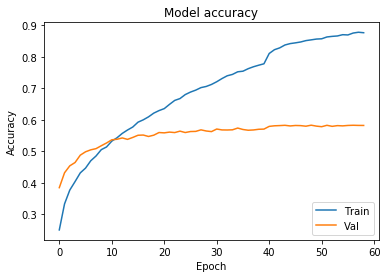

In [55]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [56]:
print('Test accuracy for Unet_dense model= {}'.format(decoder_un_dense.evaluate(gist_test_unet, y_test_one_hot)[1]))

16000/16000 [==============================] - 1s 58us/step
Test accuracy for Unet_dense model= 0.5104375


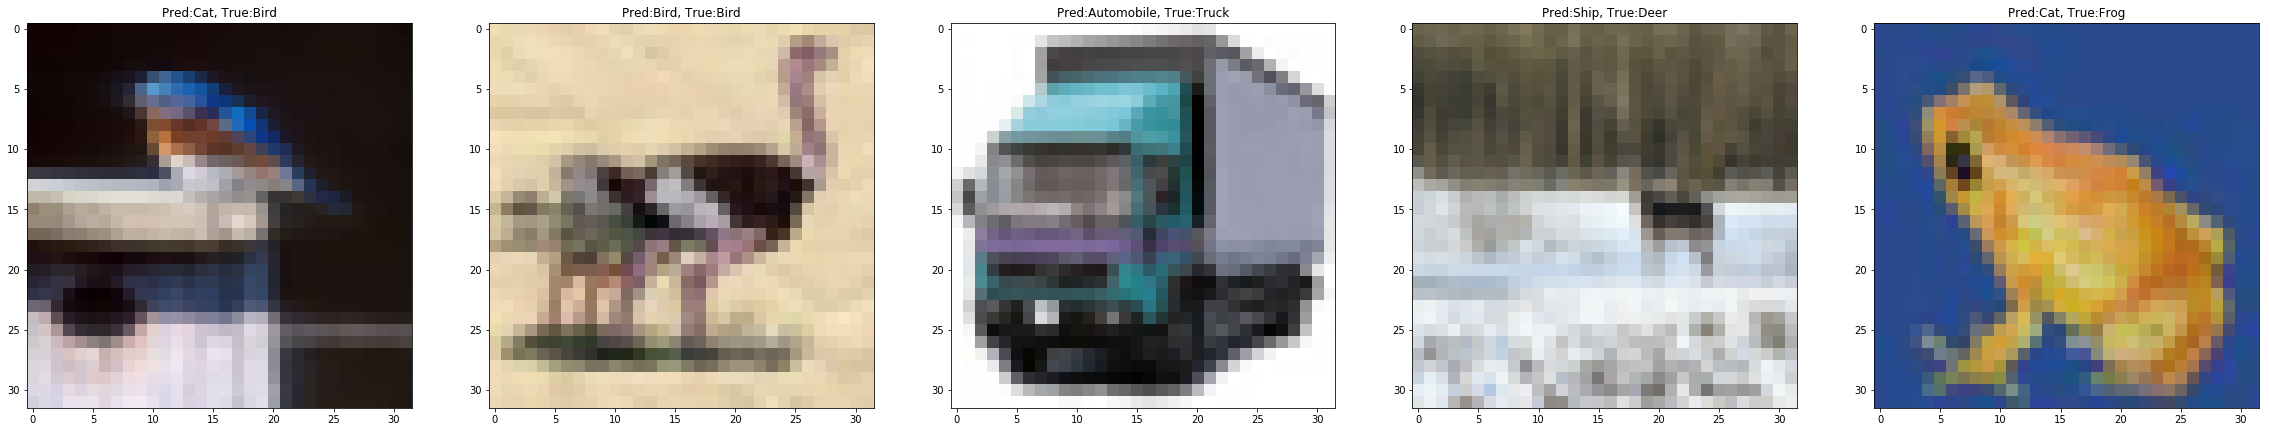

In [57]:
show_test(decoder_un_dense, gist_test_unet)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.46      0.67      0.54      1000
  Automobile       0.44      0.74      0.56      1000
        Bird       0.64      0.36      0.46      3000
         Cat       0.28      0.46      0.35      1000
        Deer       0.66      0.38      0.48      3000
         Dog       0.35      0.52      0.42      1000
        Frog       0.41      0.70      0.51      1000
       Horse       0.42      0.65      0.51      1000
        Ship       0.54      0.72      0.62      1000
       Truck       0.85      0.50      0.63      3000

    accuracy                           0.51     16000
   macro avg       0.51      0.57      0.51     16000
weighted avg       0.59      0.51      0.51     16000



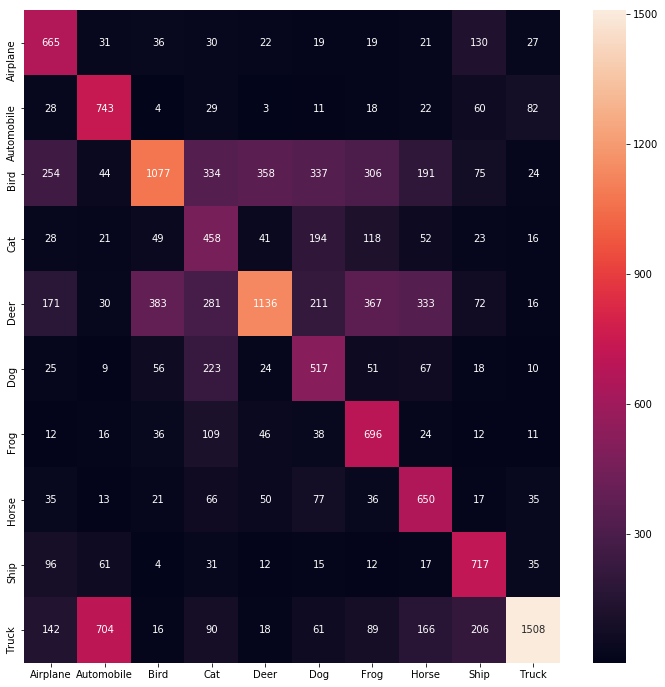

In [58]:
predictions = decoder_un_dense.predict(gist_test_unet)
report(predictions)

## Final Verdict:

1. Although, U-net is vastly superior as autoencoder compared to the convolutional autoencoder; the bottleneck features extracted from this model performs badly while classifying. The bottleneck features extracted from the simple convolutional AE model performs better in terms of classifications.

2. Convolution model with dense layer works better than stacked dense layers as classifier model.

3. The baseline model without any autoencoder outperforms all the model.

4. The model can not classify the classes properly that had less training data.

## Future Works:

I have to experiment more with different classifier models and different hyperparameters. The extracted features are expected to have the most important gist of data of the images. So, I expected models with AE to outperform the baseline model. Also, although U-net model can almost perfectly reconstruct even images in the test dataset inspite of data imbalance, the bottleneck features extracted from it as input to different classifier models performed worst, which was a shock to me.

# Extra:

## Using sklearn models instead of neural networks:

The following code snippets were used for checking with different sklearn models as classifiers instead of neural networks. I used these to see if tree based models or svm performed better than neural networks to classify test images. But I found that neural networks performed better. Also, svm took a long time to run.

In [59]:
# def solvers(func):
#     scaler_classifier = MinMaxScaler(feature_range=(0.0, 1.0))
#     pipe = Pipeline(steps=[("scaler_classifier", scaler_classifier),
#                            ("classifier", func)])

#     pipe = pipe.fit(gist_train.reshape(gist_train.shape[0], -1), y_trainf)
#     acc = pipe.score(gist_test.reshape(gist_test.shape[0], -1), y_test_final)
#     predict = pipe.predict(gist_test.reshape(gist_test.shape[0], -1))
    
#     return acc, predict

In [60]:
# lr = LogisticRegression(C=5e-1, random_state=666, solver='lbfgs', multi_class='multinomial')
# rf = RandomForestClassifier(random_state=666)
# knn = KNeighborsClassifier()
# svc = svm.SVC()

In [61]:
# acc_lr, pred_lr = solvers(lr)
# acc_lr

In [62]:
# acc_rf, pred_rf = solvers(rf)
# acc_rf

In [63]:
# acc_knn, pred_knn = solvers(knn)
# acc_knn

In [64]:
# acc_svc, pred_svc = solvers(svc)
# acc_svc

## Hyperparameter Optimization:

The following code was used for hyperparameter optimization of the classifier model. The code was updated during various iterations to suit for different types of models used.

In [65]:
# space = {
#             'units1': hp.choice('units1', [256,512,1024]),
#             'units2': hp.choice('units2', [128,256,512]),
#             'units4': hp.choice('units4', [256,512,1024]),
#             'units5': hp.choice('units5', [50,64,100,128]),
#             'dropout1': hp.uniform('dropout1', .25,.75),
#             'dropout2': hp.uniform('dropout2', .25,.75),
#             'batch_size' : hp.choice('batch_size', [64,128,256,512]),
         
#             'nb_epochs' :  200,
#             'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
#             'activation': 'relu'
#         }

In [66]:
# def f_nn(params):   
#     from keras.models import Sequential
#     from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
#     from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
#     from keras.optimizers import Adadelta, Adam, rmsprop
#     import sys

#     print ('Params testing: ', params)
#     model = Sequential()
#     model.add(Conv2D(params['units1'], 3, padding="same", activation="relu"))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D())
#     model.add(Conv2D(params['units2'], 3, padding="same", activation="relu"))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D())   

#     model.add(Flatten())
#     model.add(Dense(output_dim=params['units4'], activation="relu"))
#     model.add(Dropout(params['dropout1']))
#     model.add(Dense(output_dim=params['units5'], activation="relu"))
#     model.add(Dropout(params['dropout2']))
#     model.add(Dense(10))
#     model.add(Activation('softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])

#     model.fit(gist_train, y_train, nb_epoch=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0)

#     acc = model.evaluate(gist_valid, y_valid)[1]
#     print('Accuracy:', acc)
#     sys.stdout.flush() 
#     return {'loss': -acc, 'status': STATUS_OK}


# trials = Trials()
# best = fmin(f_nn, space, algo=tpe.suggest, max_evals=5, trials=trials)
# print('best: ')
# print(best)